In [36]:
from fastai.vision.all import *
from self_supervised.layers import *
import sklearn

In [2]:
datapath = Path("stanford-dogs-dataset/")

In [3]:
train_df = pd.read_csv(datapath/'train.csv')
test_df = pd.read_csv(datapath/'test.csv')
sample_df = pd.read_csv(datapath/'sample_train.csv')

In [4]:
train_df.shape, test_df.shape, sample_df.shape

((12000, 2), (8580, 2), (6000, 3))

In [5]:
train_df.head()

,filenames,labels
0,n02085620-Chihuahua/n02085620_5927.jpg,n02085620-Chihuahua
1,n02085620-Chihuahua/n02085620_4441.jpg,n02085620-Chihuahua
2,n02085620-Chihuahua/n02085620_1502.jpg,n02085620-Chihuahua
3,n02085620-Chihuahua/n02085620_1916.jpg,n02085620-Chihuahua
4,n02085620-Chihuahua/n02085620_13151.jpg,n02085620-Chihuahua


In [6]:
test_df.head()

,filenames,labels
0,n02085620-Chihuahua/n02085620_2650.jpg,n02085620-Chihuahua
1,n02085620-Chihuahua/n02085620_4919.jpg,n02085620-Chihuahua
2,n02085620-Chihuahua/n02085620_1765.jpg,n02085620-Chihuahua
3,n02085620-Chihuahua/n02085620_3006.jpg,n02085620-Chihuahua
4,n02085620-Chihuahua/n02085620_1492.jpg,n02085620-Chihuahua


In [7]:
sample_df.head()

,label,filename,split
0,n02085620-Chihuahua,n02085620-Chihuahua/n02085620_7292.jpg,valid
1,n02085620-Chihuahua,n02085620-Chihuahua/n02085620_500.jpg,valid
2,n02085620-Chihuahua,n02085620-Chihuahua/n02085620_1298.jpg,valid
3,n02085620-Chihuahua,n02085620-Chihuahua/n02085620_4290.jpg,valid
4,n02085620-Chihuahua,n02085620-Chihuahua/n02085620_4998.jpg,valid


### Dataset

In [9]:
def read_image(filename): return PILImage.create(datapath/'images/Images'/filename)
def read_image_size(filename): return PILImage.create(datapath/'images/Images'/filename).shape

In [12]:
# # sizes = parallel(read_image_size, filenames, progress=True)
# # Counter(sizes).most_common(10)
# [((375, 500), 1497),
#  ((333, 500), 602),
#  ((500, 375), 361),
#  ((500, 333), 196),
#  ((334, 500), 110),
#  ((332, 500), 78),
#  ((500, 500), 37),
#  ((500, 332), 37),
#  ((374, 500), 37),
#  ((357, 500), 34)]

In [13]:
# filenames = sample_df['filename'].values
# labels = sample_df['label'].values
# fn2label = dict(zip(filenames, labels))

filenames = train_df['filenames'].values
labels = train_df['labels'].values
fn2label = dict(zip(filenames, labels))

In [14]:
def read_label(filename): return fn2label[filename]

In [18]:
# train_idxs,valid_idxs = [],[]
# for idx,s in enumerate(train_df['split']):
#     if s == 'valid': valid_idxs.append(idx)
#     if s == 'train': train_idxs.append(idx)    

# len(train_idxs), len(valid_idxs)

In [19]:
size,bs = 384,32

tfms = [[read_image, ToTensor, RandomResizedCrop(size, min_scale=.75)], 
        [read_label, Categorize()]]

dsets = Datasets(filenames, tfms=tfms, 
                 splits=None)
#                  splits=[train_idxs, valid_idxs])

batch_augs = aug_transforms()
# batch_augs = []

stats = imagenet_stats

batch_tfms = [IntToFloatTensor] + batch_augs + [Normalize.from_stats(*stats)]
dls = dsets.dataloaders(bs=bs, after_batch=batch_tfms)

In [20]:
len(dls.train_ds), len(dls.valid_ds)

(12000, 0)

In [21]:
# dls.show_batch()

### Learner

In [22]:
from torch.utils.checkpoint import checkpoint_sequential
    
class CheckpointVisionTransformer(Module):
    def __init__(self, vit_model, checkpoint_nchunks=2):
        self.checkpoint_nchunks = checkpoint_nchunks
        self.vit_model = vit_model
    
    def forward_features(self, x):
        B = x.shape[0]
        x = self.vit_model.patch_embed(x)

        cls_tokens = self.vit_model.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.vit_model.pos_embed
        x = self.vit_model.pos_drop(x)
        x = checkpoint_sequential(self.vit_model.blocks, self.checkpoint_nchunks, x)
        x = self.vit_model.norm(x)[:, 0]
        x = self.vit_model.pre_logits(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.vit_model.head(x)
        return x

In [23]:
arch = "vit_base_patch16_384"
encoder = create_encoder(arch, pretrained=True, n_in=3)
encoder = CheckpointVisionTransformer(encoder, 2)
with torch.no_grad(): nf = encoder(torch.randn(2,3,size,size)).size(-1)
classifier = create_cls_module(nf, dls.c, lin_ftrs=[768], use_bn=False, first_bn=False, ps=0.)
model = nn.Sequential(encoder, classifier)

/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [24]:
classifier

Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=768, out_features=120, bias=True)
)

In [25]:
def model_splitter(m): return L(m[0], m[1]).map(params)

In [26]:
cbs = []
# if WANDB: cbs += [WandbCallback(log_preds=False,log_model=False)]
learn = Learner(dls, model, opt_func=ranger, cbs=cbs, metrics=[accuracy], splitter=model_splitter,
                loss_func=LabelSmoothingCrossEntropyFlat(0.1))
learn.to_fp16();

In [27]:
# learn.lr_find()

In [28]:
lr = 3e-3
learn.freeze()
learn.fit_one_cycle(2, lr_max=(lr), pct_start=0.5)

epoch,train_loss,valid_loss,accuracy,time
0,1.355932,None,None,02:12
1,1.114322,None,None,02:12


/opt/conda/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [29]:
lr /= 3 
learn.unfreeze()
learn.fit_one_cycle(2, lr_max=slice(lr/100, lr), pct_start=0.5)

epoch,train_loss,valid_loss,accuracy,time
0,1.023887,None,None,04:03
1,0.963057,None,None,04:04


### Evaluate on Test

In [30]:
test_filenames = test_df['filenames'].values
test_labels = test_df['labels'].values

In [31]:
test_dl = dls.test_dl(test_filenames)

In [32]:
preds = learn.get_preds(dl=test_dl)

In [33]:
pred_labels = torch.argmax(preds[0],dim=-1)

In [94]:
dls_vocab = array(dls.vocab)

In [34]:
pred_labels = dls_vocab[pred_labels]

In [35]:
np.mean(test_labels == pred_labels)

0.9271561771561772

### Confusion Matrix

In [37]:
cmat = sklearn.metrics.confusion_matrix(test_labels, pred_labels)

In [39]:
cmat

array([[ 49,   0,   0, ...,   0,   0,   0],
       [  1,  74,   0, ...,   0,   0,   0],
       [  0,   0, 142, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  47,   1,   0],
       [  0,   0,   0, ...,   1,  49,   0],
       [  0,   0,   0, ...,   0,   0,  69]])

In [69]:
triu_idxs = np.triu_indices_from(cmat,k=1)

In [85]:
cmat_triu_idxs = array(list(zip(triu_idxs[0],triu_idxs[1])))

In [87]:
most_confused_cmat_idx = cmat_triu_idxs[np.argsort(cmat[triu_idxs])[::-1]]

In [104]:
# Most confused classes
for i,j in most_confused_cmat_idx:
    print("Actual:", dls_vocab[i], "Predicted:", dls_vocab[j], "Total:", cmat[i,j])
    if cmat[i,j] == 1: break

Actual: n02109961-Eskimo_dog Predicted: n02110185-Siberian_husky Total: 25
Actual: n02093256-Staffordshire_bullterrier Predicted: n02093428-American_Staffordshire_terrier Total: 15
Actual: n02106030-collie Predicted: n02106166-Border_collie Total: 12
Actual: n02110063-malamute Predicted: n02110185-Siberian_husky Total: 10
Actual: n02105855-Shetland_sheepdog Predicted: n02106030-collie Total: 8
Actual: n02097047-miniature_schnauzer Predicted: n02097209-standard_schnauzer Total: 8
Actual: n02104029-kuvasz Predicted: n02111500-Great_Pyrenees Total: 6
Actual: n02113624-toy_poodle Predicted: n02113712-miniature_poodle Total: 6
Actual: n02089867-Walker_hound Predicted: n02089973-English_foxhound Total: 5
Actual: n02094433-Yorkshire_terrier Predicted: n02096294-Australian_terrier Total: 5
Actual: n02085936-Maltese_dog Predicted: n02098413-Lhasa Total: 5
Actual: n02087046-toy_terrier Predicted: n02107312-miniature_pinscher Total: 5
Actual: n02097298-Scotch_terrier Predicted: n02098286-West_Hig

### Wrong Predictions

In [44]:
confused_idxs = np.where(test_labels != pred_labels)[0]

In [52]:
confused_filenames = test_filenames[confused_idxs]
confused_actual = test_labels[confused_idxs]
confused_predicted = pred_labels[confused_idxs]
confused_probas = array(preds[0][confused_idxs].max(dim=-1).values)

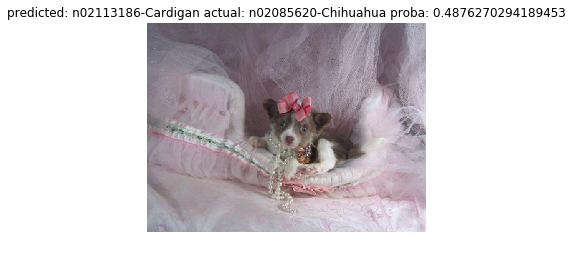

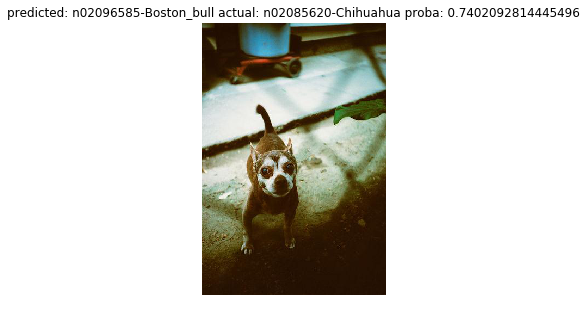

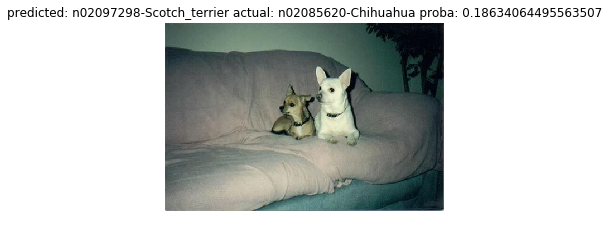

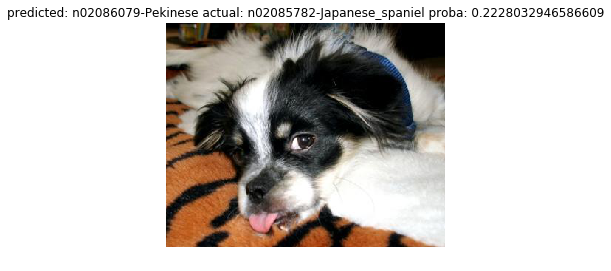

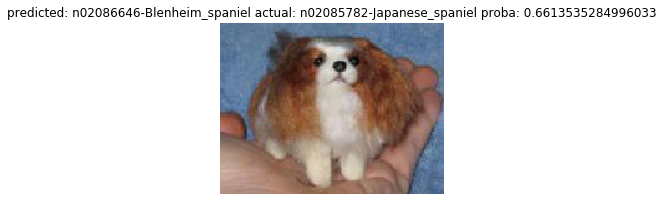

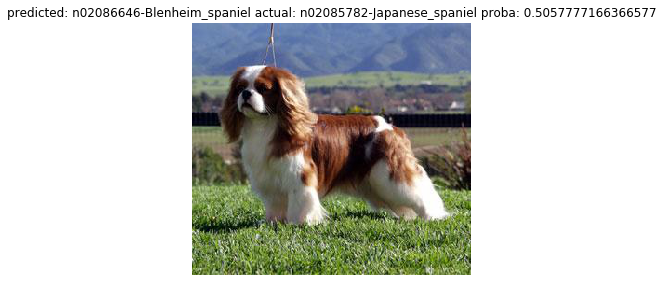

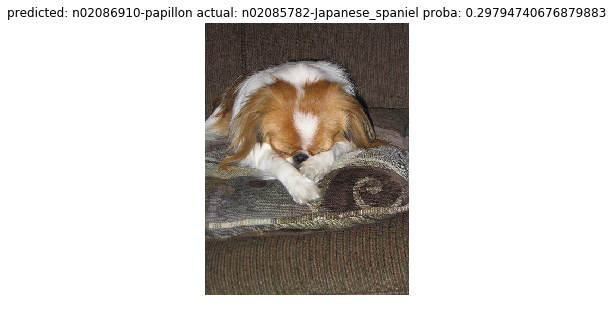

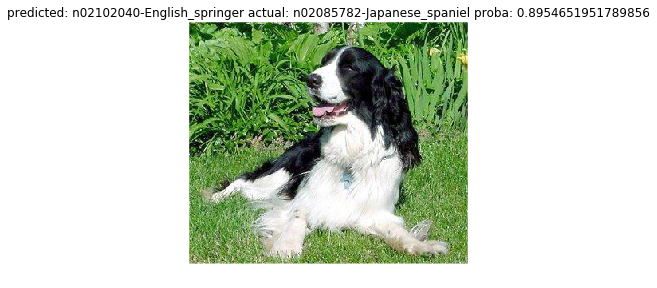

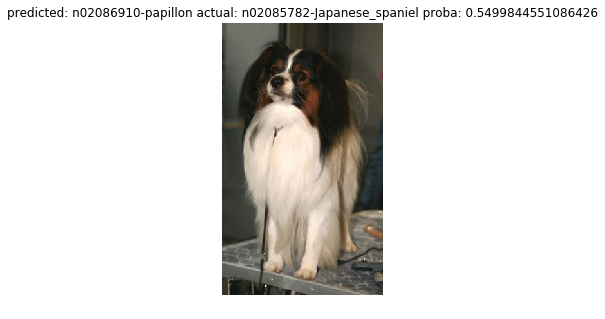

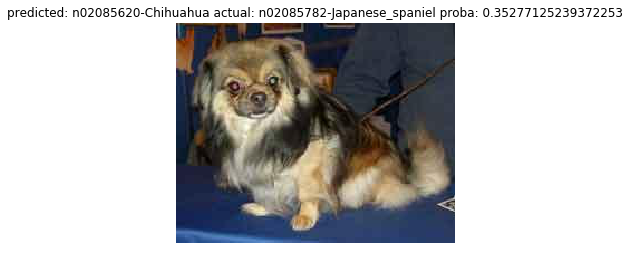

In [108]:
for fn,act,pred,prob in zip(confused_filenames[:10], confused_actual[:10], confused_predicted[:10], confused_probas[:10]):
    
    img = read_image(fn)
    title = f"predicted: {pred} actual: {act} proba: {prob}"
    
    img.show(title=title)

### Attention Map For Wrong Predictions